In [104]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import h5py

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
#         z = Input(shape=(100,))
#         img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(self.generator.layers[-1].output)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(self.generator.layers[0].input, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
        print (self.combined.summary())
    
    def build_generator(self):

        noise_shape = (1,30 )
        
#         # create model
#         seed(2017)
#         conv = Sequential()
#         conv.add(Conv1D(256, 29, input_shape=(29, 1), activation='relu'))
#         conv.add(Conv1D(256, 1, activation='relu'))
#         conv.add(Flatten())

#         conv.add(Dense(300, activation = 'relu'))
#         conv.add(Dense(100, activation = 'relu'))
#         conv.add(Dense(2, activation = 'softmax'))

#         sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)   

#         # Compile model
#         conv.compile(loss='categorical_crossentropy', optimizer=sgd)
        ##################################
        
        model_cnn = load_model('cnnv1.h5')
        
        model_cnn.layers.pop(-1)
        dense = Dense(np.prod(self.img_shape))(model_cnn.layers[-1].output)
        reshape = Reshape(self.img_shape)(dense)

        noise = Input(shape=noise_shape)

        model = Model(model_cnn.layers[0].input, reshape)
        model.summary()
#         model_cnn
#         dense = Dense(np.prod(self.img_shape))(model_cnn.layers[-2].output)
#         reshape = Reshape(self.img_shape)(dense)
        
#         noise = Input(shape=noise_shape)

#         model = Model(noise, reshape)
        return model
    
        

        # model.layers[-1].outbound_nodes = []
        # model.outputs = [model.layers[-1].output]


        
        
        ##################################
        
#         model = Sequential()

#         model.add(Dense(256, input_shape=noise_shape))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(512))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(1024))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
#         model.add(Reshape(self.img_shape))

#         model.summary()

#         noise = Input(shape=noise_shape)
#         img = model(noise)

#         return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch,30, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
            X = np.concatenate((imgs,gen_imgs))
            y = np.zeros([len(imgs)+len(gen_imgs),2])
            y[0:len(imgs),1] = 1
            y[len(imgs):,0] = 1
            d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 30, 1))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv2-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492,30, 1))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv2-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 2)                 514       
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________
____

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:253: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.718677, acc.: 46.88%] [G loss: 0.794127]
(492, 30, 1)
(492, 30)
1 [D loss: 0.682249, acc.: 51.56%] [G loss: 0.864506]
2 [D loss: 0.658642, acc.: 62.50%] [G loss: 1.173253]
3 [D loss: 0.620050, acc.: 68.75%] [G loss: 1.127192]
4 [D loss: 0.619055, acc.: 70.31%] [G loss: 1.172234]
5 [D loss: 0.612245, acc.: 71.88%] [G loss: 1.131286]
6 [D loss: 0.600988, acc.: 81.25%] [G loss: 1.101240]
7 [D loss: 0.609864, acc.: 73.44%] [G loss: 1.217522]
8 [D loss: 0.517298, acc.: 89.06%] [G loss: 1.173802]
9 [D loss: 0.536651, acc.: 82.81%] [G loss: 1.269642]
10 [D loss: 0.511678, acc.: 95.31%] [G loss: 1.191789]
11 [D loss: 0.482373, acc.: 92.19%] [G loss: 1.047374]
12 [D loss: 0.505944, acc.: 95.31%] [G loss: 1.043262]
13 [D loss: 0.508327, acc.: 87.50%] [G loss: 1.048391]
14 [D loss: 0.563099, acc.: 82.81%] [G loss: 0.972497]
15 [D loss: 0.496417, acc.: 95.31%] [G loss: 1.099597]
16 [D loss: 0.526241, acc.: 85.94%] [G loss: 0.840263]
17 [D loss: 0.517437, acc.: 92.19%] [G loss: 0.89980

154 [D loss: 0.676069, acc.: 56.25%] [G loss: 0.871479]
155 [D loss: 0.610331, acc.: 73.44%] [G loss: 0.893363]
156 [D loss: 0.666462, acc.: 60.94%] [G loss: 0.872590]
157 [D loss: 0.649566, acc.: 64.06%] [G loss: 0.897802]
158 [D loss: 0.640564, acc.: 59.38%] [G loss: 0.809312]
159 [D loss: 0.654711, acc.: 68.75%] [G loss: 0.798102]
160 [D loss: 0.631872, acc.: 71.88%] [G loss: 0.813075]
161 [D loss: 0.658101, acc.: 60.94%] [G loss: 0.798197]
162 [D loss: 0.628976, acc.: 64.06%] [G loss: 0.782031]
163 [D loss: 0.700990, acc.: 46.88%] [G loss: 0.809465]
164 [D loss: 0.613562, acc.: 71.88%] [G loss: 0.849002]
165 [D loss: 0.678885, acc.: 51.56%] [G loss: 0.787764]
166 [D loss: 0.677901, acc.: 48.44%] [G loss: 0.781582]
167 [D loss: 0.586698, acc.: 73.44%] [G loss: 0.834485]
168 [D loss: 0.632358, acc.: 57.81%] [G loss: 0.847931]
169 [D loss: 0.595185, acc.: 70.31%] [G loss: 0.843734]
170 [D loss: 0.655828, acc.: 57.81%] [G loss: 0.861978]
171 [D loss: 0.644605, acc.: 57.81%] [G loss: 0.

326 [D loss: 0.736781, acc.: 53.12%] [G loss: 0.887499]
327 [D loss: 0.721402, acc.: 54.69%] [G loss: 0.952646]
328 [D loss: 0.681838, acc.: 64.06%] [G loss: 0.885500]
329 [D loss: 0.652385, acc.: 70.31%] [G loss: 0.938738]
330 [D loss: 0.723140, acc.: 48.44%] [G loss: 1.011227]
331 [D loss: 0.652284, acc.: 59.38%] [G loss: 1.029512]
332 [D loss: 0.605825, acc.: 53.12%] [G loss: 0.941109]
333 [D loss: 0.599127, acc.: 64.06%] [G loss: 0.965430]
334 [D loss: 0.631657, acc.: 59.38%] [G loss: 1.181859]
335 [D loss: 0.628933, acc.: 60.94%] [G loss: 1.031078]
336 [D loss: 0.631838, acc.: 60.94%] [G loss: 1.026674]
337 [D loss: 0.643035, acc.: 65.62%] [G loss: 0.972642]
338 [D loss: 0.636097, acc.: 73.44%] [G loss: 0.975279]
339 [D loss: 0.549547, acc.: 85.94%] [G loss: 0.902598]
340 [D loss: 0.651706, acc.: 65.62%] [G loss: 0.921988]
341 [D loss: 0.642033, acc.: 65.62%] [G loss: 0.935603]
342 [D loss: 0.650222, acc.: 75.00%] [G loss: 0.879975]
343 [D loss: 0.563406, acc.: 78.12%] [G loss: 0.

476 [D loss: 0.689292, acc.: 46.88%] [G loss: 0.613538]
477 [D loss: 0.759024, acc.: 39.06%] [G loss: 0.683029]
478 [D loss: 0.704936, acc.: 50.00%] [G loss: 0.599110]
479 [D loss: 0.765560, acc.: 43.75%] [G loss: 0.711793]
480 [D loss: 0.740875, acc.: 46.88%] [G loss: 0.813700]
481 [D loss: 0.696138, acc.: 42.19%] [G loss: 0.813327]
482 [D loss: 0.654332, acc.: 56.25%] [G loss: 0.861525]
483 [D loss: 0.691088, acc.: 50.00%] [G loss: 0.876089]
484 [D loss: 0.624422, acc.: 68.75%] [G loss: 0.926503]
485 [D loss: 0.609652, acc.: 70.31%] [G loss: 0.938807]
486 [D loss: 0.617306, acc.: 78.12%] [G loss: 0.966737]
487 [D loss: 0.628853, acc.: 68.75%] [G loss: 0.971941]
488 [D loss: 0.659051, acc.: 64.06%] [G loss: 0.940320]
489 [D loss: 0.584513, acc.: 81.25%] [G loss: 0.926780]
490 [D loss: 0.636455, acc.: 73.44%] [G loss: 0.873288]
491 [D loss: 0.654053, acc.: 60.94%] [G loss: 0.931802]
492 [D loss: 0.686148, acc.: 62.50%] [G loss: 0.950471]
493 [D loss: 0.642841, acc.: 65.62%] [G loss: 0.

624 [D loss: 0.577104, acc.: 67.19%] [G loss: 0.919505]
625 [D loss: 0.560345, acc.: 79.69%] [G loss: 0.924778]
626 [D loss: 0.497140, acc.: 81.25%] [G loss: 0.861164]
627 [D loss: 0.586645, acc.: 60.94%] [G loss: 0.842135]
628 [D loss: 0.633153, acc.: 65.62%] [G loss: 0.802178]
629 [D loss: 0.660185, acc.: 57.81%] [G loss: 0.747408]
630 [D loss: 0.658614, acc.: 53.12%] [G loss: 0.770453]
631 [D loss: 0.680016, acc.: 50.00%] [G loss: 0.774047]
632 [D loss: 0.551329, acc.: 71.88%] [G loss: 0.794258]
633 [D loss: 0.601621, acc.: 60.94%] [G loss: 0.823720]
634 [D loss: 0.596637, acc.: 64.06%] [G loss: 0.801009]
635 [D loss: 0.578974, acc.: 76.56%] [G loss: 0.925986]
636 [D loss: 0.654179, acc.: 62.50%] [G loss: 0.923809]
637 [D loss: 0.602021, acc.: 67.19%] [G loss: 0.841504]
638 [D loss: 0.680189, acc.: 60.94%] [G loss: 0.867545]
639 [D loss: 0.626032, acc.: 54.69%] [G loss: 0.903050]
640 [D loss: 0.684300, acc.: 56.25%] [G loss: 0.853045]
641 [D loss: 0.669605, acc.: 65.62%] [G loss: 0.

794 [D loss: 0.636585, acc.: 70.31%] [G loss: 0.910434]
795 [D loss: 0.661258, acc.: 70.31%] [G loss: 0.978549]
796 [D loss: 0.609316, acc.: 82.81%] [G loss: 0.894710]
797 [D loss: 0.644632, acc.: 67.19%] [G loss: 0.868472]
798 [D loss: 0.643101, acc.: 65.62%] [G loss: 0.917302]
799 [D loss: 0.611948, acc.: 67.19%] [G loss: 0.838971]
800 [D loss: 0.758213, acc.: 45.31%] [G loss: 0.872699]
801 [D loss: 0.696149, acc.: 46.88%] [G loss: 0.853714]
802 [D loss: 0.659032, acc.: 62.50%] [G loss: 0.866258]
803 [D loss: 0.623359, acc.: 73.44%] [G loss: 0.813590]
804 [D loss: 0.615125, acc.: 68.75%] [G loss: 0.811620]
805 [D loss: 0.667656, acc.: 64.06%] [G loss: 0.805548]
806 [D loss: 0.660763, acc.: 62.50%] [G loss: 0.896090]
807 [D loss: 0.631858, acc.: 68.75%] [G loss: 0.818413]
808 [D loss: 0.597540, acc.: 76.56%] [G loss: 0.940169]
809 [D loss: 0.603580, acc.: 76.56%] [G loss: 0.960512]
810 [D loss: 0.660758, acc.: 68.75%] [G loss: 0.939931]
811 [D loss: 0.557838, acc.: 78.12%] [G loss: 1.

946 [D loss: 0.606785, acc.: 73.44%] [G loss: 0.959564]
947 [D loss: 0.614030, acc.: 67.19%] [G loss: 0.975924]
948 [D loss: 0.623728, acc.: 68.75%] [G loss: 1.004874]
949 [D loss: 0.604966, acc.: 76.56%] [G loss: 1.006447]
950 [D loss: 0.629449, acc.: 70.31%] [G loss: 0.987320]
951 [D loss: 0.622553, acc.: 73.44%] [G loss: 0.955530]
952 [D loss: 0.632940, acc.: 78.12%] [G loss: 0.914745]
953 [D loss: 0.600142, acc.: 75.00%] [G loss: 0.955748]
954 [D loss: 0.589814, acc.: 76.56%] [G loss: 0.929309]
955 [D loss: 0.636398, acc.: 68.75%] [G loss: 0.939902]
956 [D loss: 0.560705, acc.: 82.81%] [G loss: 0.989248]
957 [D loss: 0.572393, acc.: 79.69%] [G loss: 0.921619]
958 [D loss: 0.649635, acc.: 70.31%] [G loss: 0.956440]
959 [D loss: 0.630500, acc.: 78.12%] [G loss: 0.871856]
960 [D loss: 0.638355, acc.: 73.44%] [G loss: 0.869303]
961 [D loss: 0.576371, acc.: 81.25%] [G loss: 0.945458]
962 [D loss: 0.616186, acc.: 67.19%] [G loss: 0.880455]
963 [D loss: 0.527889, acc.: 87.50%] [G loss: 0.

1112 [D loss: 0.615597, acc.: 68.75%] [G loss: 0.897687]
1113 [D loss: 0.590797, acc.: 76.56%] [G loss: 0.906872]
1114 [D loss: 0.616349, acc.: 68.75%] [G loss: 0.963340]
1115 [D loss: 0.686721, acc.: 62.50%] [G loss: 0.952858]
1116 [D loss: 0.689885, acc.: 57.81%] [G loss: 0.947958]
1117 [D loss: 0.612547, acc.: 70.31%] [G loss: 0.927243]
1118 [D loss: 0.698224, acc.: 54.69%] [G loss: 0.926176]
1119 [D loss: 0.765413, acc.: 59.38%] [G loss: 0.957828]
1120 [D loss: 0.599657, acc.: 59.38%] [G loss: 0.927543]
1121 [D loss: 0.635522, acc.: 67.19%] [G loss: 0.988735]
1122 [D loss: 0.622283, acc.: 67.19%] [G loss: 0.979785]
1123 [D loss: 0.597726, acc.: 68.75%] [G loss: 1.026505]
1124 [D loss: 0.652125, acc.: 60.94%] [G loss: 1.044644]
1125 [D loss: 0.600641, acc.: 65.62%] [G loss: 1.000072]
1126 [D loss: 0.623220, acc.: 65.62%] [G loss: 1.015391]
1127 [D loss: 0.621359, acc.: 68.75%] [G loss: 1.003726]
1128 [D loss: 0.617563, acc.: 71.88%] [G loss: 0.997518]
1129 [D loss: 0.674209, acc.: 6

1279 [D loss: 0.668665, acc.: 59.38%] [G loss: 0.919340]
1280 [D loss: 0.700093, acc.: 56.25%] [G loss: 0.843722]
1281 [D loss: 0.618156, acc.: 71.88%] [G loss: 0.807111]
1282 [D loss: 0.642155, acc.: 70.31%] [G loss: 0.829335]
1283 [D loss: 0.609438, acc.: 70.31%] [G loss: 0.818344]
1284 [D loss: 0.714336, acc.: 45.31%] [G loss: 0.862979]
1285 [D loss: 0.691235, acc.: 59.38%] [G loss: 0.888305]
1286 [D loss: 0.631077, acc.: 75.00%] [G loss: 0.861533]
1287 [D loss: 0.632526, acc.: 53.12%] [G loss: 0.876539]
1288 [D loss: 0.611863, acc.: 75.00%] [G loss: 0.902216]
1289 [D loss: 0.621029, acc.: 78.12%] [G loss: 0.876473]
1290 [D loss: 0.670879, acc.: 57.81%] [G loss: 0.930157]
1291 [D loss: 0.666829, acc.: 60.94%] [G loss: 0.868490]
1292 [D loss: 0.496967, acc.: 79.69%] [G loss: 0.910015]
1293 [D loss: 0.657751, acc.: 68.75%] [G loss: 0.880753]
1294 [D loss: 0.625625, acc.: 65.62%] [G loss: 0.902694]
1295 [D loss: 0.630042, acc.: 64.06%] [G loss: 0.902055]
1296 [D loss: 0.638020, acc.: 7

1439 [D loss: 0.630992, acc.: 59.38%] [G loss: 0.899020]
1440 [D loss: 0.687952, acc.: 56.25%] [G loss: 0.835183]
1441 [D loss: 0.607742, acc.: 64.06%] [G loss: 0.842316]
1442 [D loss: 0.655505, acc.: 59.38%] [G loss: 0.912862]
1443 [D loss: 0.626698, acc.: 68.75%] [G loss: 0.874255]
1444 [D loss: 0.656472, acc.: 54.69%] [G loss: 0.930365]
1445 [D loss: 0.633335, acc.: 65.62%] [G loss: 0.957996]
1446 [D loss: 0.629320, acc.: 73.44%] [G loss: 1.034096]
1447 [D loss: 0.671873, acc.: 54.69%] [G loss: 0.994098]
1448 [D loss: 0.588407, acc.: 76.56%] [G loss: 1.075740]
1449 [D loss: 0.549020, acc.: 70.31%] [G loss: 1.038679]
1450 [D loss: 0.609615, acc.: 67.19%] [G loss: 1.018086]
1451 [D loss: 0.606182, acc.: 68.75%] [G loss: 1.120998]
1452 [D loss: 0.595284, acc.: 68.75%] [G loss: 1.052030]
1453 [D loss: 0.585918, acc.: 73.44%] [G loss: 1.169786]
1454 [D loss: 0.600306, acc.: 73.44%] [G loss: 0.980413]
1455 [D loss: 0.604584, acc.: 67.19%] [G loss: 0.927041]
1456 [D loss: 0.609695, acc.: 7

1601 [D loss: 0.610781, acc.: 64.06%] [G loss: 0.867693]
1602 [D loss: 0.566407, acc.: 70.31%] [G loss: 0.803498]
1603 [D loss: 0.596989, acc.: 73.44%] [G loss: 0.876466]
1604 [D loss: 0.608378, acc.: 60.94%] [G loss: 0.883251]
1605 [D loss: 0.588134, acc.: 70.31%] [G loss: 0.911556]
1606 [D loss: 0.620293, acc.: 60.94%] [G loss: 0.871294]
1607 [D loss: 0.621278, acc.: 71.88%] [G loss: 0.869074]
1608 [D loss: 0.590566, acc.: 64.06%] [G loss: 0.879830]
1609 [D loss: 0.591915, acc.: 78.12%] [G loss: 0.888689]
1610 [D loss: 0.612888, acc.: 78.12%] [G loss: 0.849194]
1611 [D loss: 0.673752, acc.: 54.69%] [G loss: 0.894766]
1612 [D loss: 0.483668, acc.: 79.69%] [G loss: 0.905510]
1613 [D loss: 0.538324, acc.: 75.00%] [G loss: 0.843433]
1614 [D loss: 0.694472, acc.: 51.56%] [G loss: 0.865018]
1615 [D loss: 0.635396, acc.: 60.94%] [G loss: 0.892958]
1616 [D loss: 0.637983, acc.: 64.06%] [G loss: 0.995215]
1617 [D loss: 0.604203, acc.: 71.88%] [G loss: 0.980487]
1618 [D loss: 0.568394, acc.: 7

1769 [D loss: 0.657487, acc.: 62.50%] [G loss: 0.895810]
1770 [D loss: 0.668290, acc.: 54.69%] [G loss: 0.966320]
1771 [D loss: 0.568717, acc.: 76.56%] [G loss: 0.901429]
1772 [D loss: 0.640001, acc.: 65.62%] [G loss: 0.916596]
1773 [D loss: 0.593776, acc.: 75.00%] [G loss: 0.821324]
1774 [D loss: 0.573523, acc.: 73.44%] [G loss: 0.840420]
1775 [D loss: 0.642761, acc.: 62.50%] [G loss: 0.819101]
1776 [D loss: 0.590311, acc.: 78.12%] [G loss: 0.837704]
1777 [D loss: 0.613457, acc.: 64.06%] [G loss: 0.828611]
1778 [D loss: 0.625618, acc.: 64.06%] [G loss: 0.834115]
1779 [D loss: 0.634667, acc.: 62.50%] [G loss: 0.825412]
1780 [D loss: 0.669716, acc.: 59.38%] [G loss: 0.851982]
1781 [D loss: 0.661169, acc.: 57.81%] [G loss: 0.914123]
1782 [D loss: 0.611236, acc.: 75.00%] [G loss: 0.928444]
1783 [D loss: 0.664205, acc.: 62.50%] [G loss: 0.914347]
1784 [D loss: 0.627425, acc.: 60.94%] [G loss: 0.989729]
1785 [D loss: 0.561626, acc.: 75.00%] [G loss: 0.961246]
1786 [D loss: 0.642542, acc.: 5

1916 [D loss: 0.621171, acc.: 68.75%] [G loss: 0.848477]
1917 [D loss: 0.562423, acc.: 73.44%] [G loss: 0.869282]
1918 [D loss: 0.610104, acc.: 71.88%] [G loss: 0.905004]
1919 [D loss: 0.623901, acc.: 67.19%] [G loss: 0.872699]
1920 [D loss: 0.583820, acc.: 81.25%] [G loss: 0.858041]
1921 [D loss: 0.568848, acc.: 71.88%] [G loss: 0.892134]
1922 [D loss: 0.544407, acc.: 75.00%] [G loss: 0.887089]
1923 [D loss: 0.580536, acc.: 62.50%] [G loss: 0.915092]
1924 [D loss: 0.578399, acc.: 68.75%] [G loss: 0.880747]
1925 [D loss: 0.690575, acc.: 59.38%] [G loss: 0.917257]
1926 [D loss: 0.601730, acc.: 78.12%] [G loss: 0.894331]
1927 [D loss: 0.662637, acc.: 64.06%] [G loss: 0.892259]
1928 [D loss: 0.605184, acc.: 75.00%] [G loss: 0.804721]
1929 [D loss: 0.653257, acc.: 68.75%] [G loss: 0.796576]
1930 [D loss: 0.644802, acc.: 67.19%] [G loss: 0.809122]
1931 [D loss: 0.583388, acc.: 75.00%] [G loss: 0.851036]
1932 [D loss: 0.615831, acc.: 65.62%] [G loss: 0.845077]
1933 [D loss: 0.597683, acc.: 6

2071 [D loss: 0.608257, acc.: 67.19%] [G loss: 0.990672]
2072 [D loss: 0.616912, acc.: 67.19%] [G loss: 0.961375]
2073 [D loss: 0.566044, acc.: 70.31%] [G loss: 0.948813]
2074 [D loss: 0.494664, acc.: 87.50%] [G loss: 0.915747]
2075 [D loss: 0.632347, acc.: 64.06%] [G loss: 0.973468]
2076 [D loss: 0.566615, acc.: 70.31%] [G loss: 1.078815]
2077 [D loss: 0.612909, acc.: 79.69%] [G loss: 0.945871]
2078 [D loss: 0.600283, acc.: 73.44%] [G loss: 0.987368]
2079 [D loss: 0.635352, acc.: 64.06%] [G loss: 0.811473]
2080 [D loss: 0.576745, acc.: 70.31%] [G loss: 0.761647]
2081 [D loss: 0.588475, acc.: 64.06%] [G loss: 0.837604]
2082 [D loss: 0.601282, acc.: 67.19%] [G loss: 0.862725]
2083 [D loss: 0.607904, acc.: 73.44%] [G loss: 0.928529]
2084 [D loss: 0.562005, acc.: 81.25%] [G loss: 0.833424]
2085 [D loss: 0.613301, acc.: 75.00%] [G loss: 0.801252]
2086 [D loss: 0.627133, acc.: 68.75%] [G loss: 0.854552]
2087 [D loss: 0.645805, acc.: 60.94%] [G loss: 0.837316]
2088 [D loss: 0.536385, acc.: 8

2239 [D loss: 0.586584, acc.: 71.88%] [G loss: 0.906053]
2240 [D loss: 0.638025, acc.: 67.19%] [G loss: 0.883163]
2241 [D loss: 0.634619, acc.: 65.62%] [G loss: 0.891890]
2242 [D loss: 0.574500, acc.: 73.44%] [G loss: 0.952411]
2243 [D loss: 0.573860, acc.: 73.44%] [G loss: 0.894154]
2244 [D loss: 0.560516, acc.: 70.31%] [G loss: 0.862475]
2245 [D loss: 0.659324, acc.: 57.81%] [G loss: 0.882066]
2246 [D loss: 0.618131, acc.: 71.88%] [G loss: 0.948629]
2247 [D loss: 0.539918, acc.: 81.25%] [G loss: 0.857312]
2248 [D loss: 0.578294, acc.: 68.75%] [G loss: 0.926737]
2249 [D loss: 0.633258, acc.: 65.62%] [G loss: 0.848462]
2250 [D loss: 0.573972, acc.: 75.00%] [G loss: 0.893033]
2251 [D loss: 0.635800, acc.: 68.75%] [G loss: 0.885931]
2252 [D loss: 0.560497, acc.: 84.38%] [G loss: 0.912245]
2253 [D loss: 0.652219, acc.: 65.62%] [G loss: 0.778703]
2254 [D loss: 0.694811, acc.: 57.81%] [G loss: 0.847894]
2255 [D loss: 0.665426, acc.: 59.38%] [G loss: 0.853612]
2256 [D loss: 0.739997, acc.: 5

2406 [D loss: 0.632080, acc.: 67.19%] [G loss: 0.822901]
2407 [D loss: 0.618100, acc.: 70.31%] [G loss: 0.988424]
2408 [D loss: 0.612196, acc.: 67.19%] [G loss: 0.912195]
2409 [D loss: 0.610120, acc.: 68.75%] [G loss: 1.013638]
2410 [D loss: 0.521168, acc.: 78.12%] [G loss: 0.969074]
2411 [D loss: 0.628796, acc.: 62.50%] [G loss: 1.014861]
2412 [D loss: 0.585452, acc.: 64.06%] [G loss: 1.026676]
2413 [D loss: 0.514986, acc.: 82.81%] [G loss: 1.034283]
2414 [D loss: 0.679680, acc.: 57.81%] [G loss: 0.963933]
2415 [D loss: 0.556148, acc.: 67.19%] [G loss: 1.016598]
2416 [D loss: 0.532153, acc.: 81.25%] [G loss: 0.959470]
2417 [D loss: 0.561531, acc.: 71.88%] [G loss: 0.904804]
2418 [D loss: 0.553052, acc.: 76.56%] [G loss: 0.920423]
2419 [D loss: 0.647430, acc.: 71.88%] [G loss: 0.965321]
2420 [D loss: 0.585112, acc.: 71.88%] [G loss: 0.900859]
2421 [D loss: 0.558005, acc.: 81.25%] [G loss: 0.876224]
2422 [D loss: 0.636927, acc.: 64.06%] [G loss: 0.866958]
2423 [D loss: 0.576311, acc.: 7

2563 [D loss: 0.607541, acc.: 62.50%] [G loss: 0.836431]
2564 [D loss: 0.610139, acc.: 70.31%] [G loss: 0.894722]
2565 [D loss: 0.591202, acc.: 75.00%] [G loss: 0.825104]
2566 [D loss: 0.559330, acc.: 70.31%] [G loss: 0.832897]
2567 [D loss: 0.544851, acc.: 67.19%] [G loss: 0.874031]
2568 [D loss: 0.586637, acc.: 64.06%] [G loss: 0.939020]
2569 [D loss: 0.590587, acc.: 67.19%] [G loss: 0.955923]
2570 [D loss: 0.641008, acc.: 56.25%] [G loss: 0.925785]
2571 [D loss: 0.607895, acc.: 62.50%] [G loss: 0.939833]
2572 [D loss: 0.623547, acc.: 68.75%] [G loss: 0.867046]
2573 [D loss: 0.634104, acc.: 59.38%] [G loss: 0.948124]
2574 [D loss: 0.585711, acc.: 73.44%] [G loss: 0.911390]
2575 [D loss: 0.606508, acc.: 64.06%] [G loss: 0.915032]
2576 [D loss: 0.618230, acc.: 70.31%] [G loss: 0.936397]
2577 [D loss: 0.608369, acc.: 75.00%] [G loss: 0.952328]
2578 [D loss: 0.635704, acc.: 62.50%] [G loss: 0.939735]
2579 [D loss: 0.540465, acc.: 75.00%] [G loss: 0.978200]
2580 [D loss: 0.554866, acc.: 7

2726 [D loss: 0.628075, acc.: 67.19%] [G loss: 0.841372]
2727 [D loss: 0.644384, acc.: 64.06%] [G loss: 0.907990]
2728 [D loss: 0.588136, acc.: 71.88%] [G loss: 0.900930]
2729 [D loss: 0.543146, acc.: 67.19%] [G loss: 0.997147]
2730 [D loss: 0.500433, acc.: 89.06%] [G loss: 0.983676]
2731 [D loss: 0.581169, acc.: 71.88%] [G loss: 0.977402]
2732 [D loss: 0.513798, acc.: 81.25%] [G loss: 0.892722]
2733 [D loss: 0.519894, acc.: 78.12%] [G loss: 0.947204]
2734 [D loss: 0.623742, acc.: 62.50%] [G loss: 0.916517]
2735 [D loss: 0.588682, acc.: 71.88%] [G loss: 0.913651]
2736 [D loss: 0.589436, acc.: 65.62%] [G loss: 1.032886]
2737 [D loss: 0.556235, acc.: 81.25%] [G loss: 0.953790]
2738 [D loss: 0.494581, acc.: 84.38%] [G loss: 0.985139]
2739 [D loss: 0.593093, acc.: 67.19%] [G loss: 1.018425]
2740 [D loss: 0.599432, acc.: 64.06%] [G loss: 0.995125]
2741 [D loss: 0.554248, acc.: 67.19%] [G loss: 0.966029]
2742 [D loss: 0.586158, acc.: 73.44%] [G loss: 0.928496]
2743 [D loss: 0.600205, acc.: 6

2890 [D loss: 0.580998, acc.: 75.00%] [G loss: 0.970323]
2891 [D loss: 0.642248, acc.: 60.94%] [G loss: 0.947336]
2892 [D loss: 0.640165, acc.: 60.94%] [G loss: 1.038000]
2893 [D loss: 0.472315, acc.: 75.00%] [G loss: 0.882281]
2894 [D loss: 0.576946, acc.: 68.75%] [G loss: 0.821019]
2895 [D loss: 0.540902, acc.: 78.12%] [G loss: 0.889305]
2896 [D loss: 0.600989, acc.: 67.19%] [G loss: 0.878864]
2897 [D loss: 0.601110, acc.: 65.62%] [G loss: 0.880196]
2898 [D loss: 0.582192, acc.: 65.62%] [G loss: 0.856933]
2899 [D loss: 0.571775, acc.: 65.62%] [G loss: 0.851683]
2900 [D loss: 0.713522, acc.: 54.69%] [G loss: 0.911439]
2901 [D loss: 0.591592, acc.: 76.56%] [G loss: 1.029254]
2902 [D loss: 0.613361, acc.: 62.50%] [G loss: 0.990071]
2903 [D loss: 0.613283, acc.: 68.75%] [G loss: 0.957404]
2904 [D loss: 0.574889, acc.: 70.31%] [G loss: 0.943310]
2905 [D loss: 0.662830, acc.: 56.25%] [G loss: 1.031999]
2906 [D loss: 0.641499, acc.: 56.25%] [G loss: 0.984298]
2907 [D loss: 0.553795, acc.: 7

3049 [D loss: 0.558913, acc.: 76.56%] [G loss: 0.902140]
3050 [D loss: 0.514472, acc.: 71.88%] [G loss: 1.043619]
3051 [D loss: 0.586462, acc.: 67.19%] [G loss: 0.959408]
3052 [D loss: 0.615536, acc.: 64.06%] [G loss: 0.881557]
3053 [D loss: 0.538976, acc.: 78.12%] [G loss: 0.945985]
3054 [D loss: 0.514827, acc.: 79.69%] [G loss: 0.994483]
3055 [D loss: 0.564920, acc.: 75.00%] [G loss: 0.977760]
3056 [D loss: 0.494085, acc.: 82.81%] [G loss: 0.959739]
3057 [D loss: 0.571521, acc.: 73.44%] [G loss: 0.899110]
3058 [D loss: 0.567479, acc.: 76.56%] [G loss: 1.048012]
3059 [D loss: 0.611120, acc.: 68.75%] [G loss: 1.028489]
3060 [D loss: 0.609832, acc.: 68.75%] [G loss: 0.924917]
3061 [D loss: 0.581407, acc.: 67.19%] [G loss: 0.959154]
3062 [D loss: 0.599537, acc.: 71.88%] [G loss: 0.964527]
3063 [D loss: 0.522151, acc.: 75.00%] [G loss: 0.980909]
3064 [D loss: 0.635544, acc.: 67.19%] [G loss: 0.913186]
3065 [D loss: 0.574669, acc.: 70.31%] [G loss: 0.917722]
3066 [D loss: 0.547504, acc.: 7

3215 [D loss: 0.554968, acc.: 75.00%] [G loss: 0.993324]
3216 [D loss: 0.535519, acc.: 70.31%] [G loss: 1.035339]
3217 [D loss: 0.586099, acc.: 64.06%] [G loss: 0.922745]
3218 [D loss: 0.487828, acc.: 84.38%] [G loss: 0.979413]
3219 [D loss: 0.579324, acc.: 64.06%] [G loss: 1.028738]
3220 [D loss: 0.505056, acc.: 82.81%] [G loss: 0.984508]
3221 [D loss: 0.565991, acc.: 75.00%] [G loss: 1.006760]
3222 [D loss: 0.549265, acc.: 81.25%] [G loss: 0.908925]
3223 [D loss: 0.575115, acc.: 73.44%] [G loss: 0.935452]
3224 [D loss: 0.618543, acc.: 62.50%] [G loss: 0.882481]
3225 [D loss: 0.698288, acc.: 53.12%] [G loss: 0.953652]
3226 [D loss: 0.615572, acc.: 73.44%] [G loss: 1.007589]
3227 [D loss: 0.617104, acc.: 65.62%] [G loss: 0.992081]
3228 [D loss: 0.681257, acc.: 51.56%] [G loss: 1.105235]
3229 [D loss: 0.516588, acc.: 76.56%] [G loss: 0.926607]
3230 [D loss: 0.555530, acc.: 73.44%] [G loss: 0.976731]
3231 [D loss: 0.586133, acc.: 67.19%] [G loss: 0.987773]
3232 [D loss: 0.555331, acc.: 7

3379 [D loss: 0.636114, acc.: 59.38%] [G loss: 0.944518]
3380 [D loss: 0.486018, acc.: 78.12%] [G loss: 0.881292]
3381 [D loss: 0.620319, acc.: 67.19%] [G loss: 0.890166]
3382 [D loss: 0.554583, acc.: 76.56%] [G loss: 1.018498]
3383 [D loss: 0.528061, acc.: 71.88%] [G loss: 0.974659]
3384 [D loss: 0.604493, acc.: 73.44%] [G loss: 0.958895]
3385 [D loss: 0.487238, acc.: 81.25%] [G loss: 0.808077]
3386 [D loss: 0.633037, acc.: 68.75%] [G loss: 0.896137]
3387 [D loss: 0.517821, acc.: 78.12%] [G loss: 1.053787]
3388 [D loss: 0.523326, acc.: 75.00%] [G loss: 0.997977]
3389 [D loss: 0.569742, acc.: 76.56%] [G loss: 1.116302]
3390 [D loss: 0.526939, acc.: 78.12%] [G loss: 1.108014]
3391 [D loss: 0.603553, acc.: 67.19%] [G loss: 1.216628]
3392 [D loss: 0.517092, acc.: 76.56%] [G loss: 1.171885]
3393 [D loss: 0.470601, acc.: 81.25%] [G loss: 1.193254]
3394 [D loss: 0.488774, acc.: 75.00%] [G loss: 1.183298]
3395 [D loss: 0.539356, acc.: 75.00%] [G loss: 1.168496]
3396 [D loss: 0.535259, acc.: 7

3545 [D loss: 0.503522, acc.: 79.69%] [G loss: 0.944154]
3546 [D loss: 0.527579, acc.: 81.25%] [G loss: 0.957337]
3547 [D loss: 0.570827, acc.: 70.31%] [G loss: 1.022483]
3548 [D loss: 0.522433, acc.: 82.81%] [G loss: 1.002085]
3549 [D loss: 0.520458, acc.: 87.50%] [G loss: 0.966469]
3550 [D loss: 0.452580, acc.: 89.06%] [G loss: 1.009394]
3551 [D loss: 0.498787, acc.: 81.25%] [G loss: 0.992305]
3552 [D loss: 0.582340, acc.: 76.56%] [G loss: 0.898982]
3553 [D loss: 0.494438, acc.: 82.81%] [G loss: 0.909764]
3554 [D loss: 0.575183, acc.: 62.50%] [G loss: 1.016317]
3555 [D loss: 0.535329, acc.: 82.81%] [G loss: 1.002782]
3556 [D loss: 0.556759, acc.: 65.62%] [G loss: 0.942311]
3557 [D loss: 0.482819, acc.: 92.19%] [G loss: 0.919181]
3558 [D loss: 0.542736, acc.: 76.56%] [G loss: 0.935452]
3559 [D loss: 0.626645, acc.: 71.88%] [G loss: 0.908488]
3560 [D loss: 0.623431, acc.: 62.50%] [G loss: 0.931023]
3561 [D loss: 0.603880, acc.: 54.69%] [G loss: 0.931278]
3562 [D loss: 0.542306, acc.: 8

3712 [D loss: 0.533466, acc.: 70.31%] [G loss: 1.014713]
3713 [D loss: 0.563456, acc.: 64.06%] [G loss: 0.994457]
3714 [D loss: 0.675686, acc.: 59.38%] [G loss: 1.013138]
3715 [D loss: 0.613176, acc.: 59.38%] [G loss: 0.971609]
3716 [D loss: 0.543909, acc.: 81.25%] [G loss: 0.920869]
3717 [D loss: 0.569513, acc.: 78.12%] [G loss: 0.965426]
3718 [D loss: 0.514465, acc.: 85.94%] [G loss: 0.927085]
3719 [D loss: 0.571406, acc.: 73.44%] [G loss: 0.984285]
3720 [D loss: 0.476798, acc.: 82.81%] [G loss: 0.957890]
3721 [D loss: 0.473668, acc.: 81.25%] [G loss: 1.016822]
3722 [D loss: 0.487778, acc.: 75.00%] [G loss: 1.066138]
3723 [D loss: 0.556160, acc.: 73.44%] [G loss: 0.979175]
3724 [D loss: 0.547981, acc.: 81.25%] [G loss: 0.975521]
3725 [D loss: 0.526382, acc.: 78.12%] [G loss: 1.052289]
3726 [D loss: 0.592751, acc.: 64.06%] [G loss: 0.991743]
3727 [D loss: 0.539363, acc.: 75.00%] [G loss: 0.936430]
3728 [D loss: 0.524805, acc.: 79.69%] [G loss: 1.098424]
3729 [D loss: 0.506745, acc.: 8

3878 [D loss: 0.569932, acc.: 67.19%] [G loss: 0.897754]
3879 [D loss: 0.470777, acc.: 79.69%] [G loss: 0.921478]
3880 [D loss: 0.646134, acc.: 56.25%] [G loss: 1.002853]
3881 [D loss: 0.526811, acc.: 73.44%] [G loss: 0.954071]
3882 [D loss: 0.573447, acc.: 67.19%] [G loss: 1.073931]
3883 [D loss: 0.510652, acc.: 76.56%] [G loss: 0.957194]
3884 [D loss: 0.511777, acc.: 81.25%] [G loss: 1.025124]
3885 [D loss: 0.534006, acc.: 76.56%] [G loss: 1.147501]
3886 [D loss: 0.473389, acc.: 76.56%] [G loss: 1.104618]
3887 [D loss: 0.532391, acc.: 75.00%] [G loss: 1.144326]
3888 [D loss: 0.528803, acc.: 84.38%] [G loss: 1.046467]
3889 [D loss: 0.515048, acc.: 71.88%] [G loss: 1.089442]
3890 [D loss: 0.449467, acc.: 84.38%] [G loss: 0.967145]
3891 [D loss: 0.491101, acc.: 82.81%] [G loss: 0.985469]
3892 [D loss: 0.620790, acc.: 68.75%] [G loss: 0.881349]
3893 [D loss: 0.540425, acc.: 70.31%] [G loss: 0.853426]
3894 [D loss: 0.612693, acc.: 62.50%] [G loss: 0.850151]
3895 [D loss: 0.594908, acc.: 6

4042 [D loss: 0.415804, acc.: 87.50%] [G loss: 1.102348]
4043 [D loss: 0.544724, acc.: 78.12%] [G loss: 1.101454]
4044 [D loss: 0.529334, acc.: 75.00%] [G loss: 0.971999]
4045 [D loss: 0.462082, acc.: 79.69%] [G loss: 1.003378]
4046 [D loss: 0.470740, acc.: 82.81%] [G loss: 0.986951]
4047 [D loss: 0.659537, acc.: 56.25%] [G loss: 1.024453]
4048 [D loss: 0.491796, acc.: 84.38%] [G loss: 1.028500]
4049 [D loss: 0.557187, acc.: 67.19%] [G loss: 0.902162]
4050 [D loss: 0.514546, acc.: 84.38%] [G loss: 0.954197]
4051 [D loss: 0.484239, acc.: 81.25%] [G loss: 0.923594]
4052 [D loss: 0.527601, acc.: 79.69%] [G loss: 0.962465]
4053 [D loss: 0.554051, acc.: 76.56%] [G loss: 0.891056]
4054 [D loss: 0.571258, acc.: 79.69%] [G loss: 1.001276]
4055 [D loss: 0.534003, acc.: 82.81%] [G loss: 0.965880]
4056 [D loss: 0.501503, acc.: 84.38%] [G loss: 0.943272]
4057 [D loss: 0.603404, acc.: 64.06%] [G loss: 0.865254]
4058 [D loss: 0.527787, acc.: 90.62%] [G loss: 0.853215]
4059 [D loss: 0.586568, acc.: 7

4206 [D loss: 0.564540, acc.: 71.88%] [G loss: 1.000094]
4207 [D loss: 0.526327, acc.: 73.44%] [G loss: 0.950350]
4208 [D loss: 0.513027, acc.: 81.25%] [G loss: 1.002164]
4209 [D loss: 0.482518, acc.: 76.56%] [G loss: 1.016330]
4210 [D loss: 0.555698, acc.: 76.56%] [G loss: 1.175742]
4211 [D loss: 0.539994, acc.: 65.62%] [G loss: 1.067332]
4212 [D loss: 0.509059, acc.: 79.69%] [G loss: 1.076803]
4213 [D loss: 0.577530, acc.: 64.06%] [G loss: 1.034541]
4214 [D loss: 0.498211, acc.: 78.12%] [G loss: 0.987975]
4215 [D loss: 0.579289, acc.: 67.19%] [G loss: 0.912587]
4216 [D loss: 0.609673, acc.: 64.06%] [G loss: 0.926789]
4217 [D loss: 0.615881, acc.: 70.31%] [G loss: 0.898582]
4218 [D loss: 0.678167, acc.: 57.81%] [G loss: 0.966504]
4219 [D loss: 0.552495, acc.: 67.19%] [G loss: 0.995400]
4220 [D loss: 0.643965, acc.: 60.94%] [G loss: 1.039489]
4221 [D loss: 0.568922, acc.: 60.94%] [G loss: 1.012739]
4222 [D loss: 0.433911, acc.: 84.38%] [G loss: 1.123101]
4223 [D loss: 0.498729, acc.: 7

4372 [D loss: 0.530015, acc.: 73.44%] [G loss: 0.977502]
4373 [D loss: 0.534125, acc.: 75.00%] [G loss: 1.123323]
4374 [D loss: 0.443517, acc.: 84.38%] [G loss: 1.095341]
4375 [D loss: 0.485347, acc.: 78.12%] [G loss: 1.251888]
4376 [D loss: 0.552844, acc.: 71.88%] [G loss: 1.154798]
4377 [D loss: 0.583048, acc.: 73.44%] [G loss: 1.009122]
4378 [D loss: 0.547151, acc.: 73.44%] [G loss: 1.002834]
4379 [D loss: 0.469856, acc.: 84.38%] [G loss: 0.965851]
4380 [D loss: 0.438736, acc.: 92.19%] [G loss: 1.094226]
4381 [D loss: 0.516201, acc.: 73.44%] [G loss: 1.007410]
4382 [D loss: 0.503923, acc.: 73.44%] [G loss: 1.022349]
4383 [D loss: 0.540559, acc.: 68.75%] [G loss: 1.030986]
4384 [D loss: 0.536650, acc.: 68.75%] [G loss: 0.993778]
4385 [D loss: 0.584243, acc.: 64.06%] [G loss: 1.050484]
4386 [D loss: 0.451490, acc.: 78.12%] [G loss: 0.988393]
4387 [D loss: 0.557448, acc.: 68.75%] [G loss: 1.071851]
4388 [D loss: 0.629360, acc.: 59.38%] [G loss: 0.938472]
4389 [D loss: 0.579716, acc.: 6

4536 [D loss: 0.476824, acc.: 90.62%] [G loss: 0.929703]
4537 [D loss: 0.566287, acc.: 70.31%] [G loss: 0.976146]
4538 [D loss: 0.533908, acc.: 70.31%] [G loss: 1.062374]
4539 [D loss: 0.467359, acc.: 84.38%] [G loss: 1.099818]
4540 [D loss: 0.558450, acc.: 67.19%] [G loss: 1.145560]
4541 [D loss: 0.545255, acc.: 71.88%] [G loss: 1.061297]
4542 [D loss: 0.565411, acc.: 67.19%] [G loss: 1.011893]
4543 [D loss: 0.480660, acc.: 71.88%] [G loss: 1.037607]
4544 [D loss: 0.527591, acc.: 65.62%] [G loss: 0.975455]
4545 [D loss: 0.517654, acc.: 78.12%] [G loss: 1.062124]
4546 [D loss: 0.599753, acc.: 71.88%] [G loss: 0.899852]
4547 [D loss: 0.469416, acc.: 84.38%] [G loss: 0.944510]
4548 [D loss: 0.529652, acc.: 82.81%] [G loss: 0.924484]
4549 [D loss: 0.492953, acc.: 90.62%] [G loss: 1.024653]
4550 [D loss: 0.523108, acc.: 73.44%] [G loss: 1.036218]
4551 [D loss: 0.539494, acc.: 73.44%] [G loss: 0.957434]
4552 [D loss: 0.506876, acc.: 87.50%] [G loss: 1.057590]
4553 [D loss: 0.521099, acc.: 7

4701 [D loss: 0.538689, acc.: 70.31%] [G loss: 1.069300]
4702 [D loss: 0.435618, acc.: 84.38%] [G loss: 0.953863]
4703 [D loss: 0.588826, acc.: 67.19%] [G loss: 0.959967]
4704 [D loss: 0.483490, acc.: 75.00%] [G loss: 1.037929]
4705 [D loss: 0.475550, acc.: 81.25%] [G loss: 1.054869]
4706 [D loss: 0.429358, acc.: 90.62%] [G loss: 1.031659]
4707 [D loss: 0.489376, acc.: 78.12%] [G loss: 1.070413]
4708 [D loss: 0.523043, acc.: 73.44%] [G loss: 1.105064]
4709 [D loss: 0.493091, acc.: 82.81%] [G loss: 1.078643]
4710 [D loss: 0.468644, acc.: 76.56%] [G loss: 1.198583]
4711 [D loss: 0.516213, acc.: 70.31%] [G loss: 1.069934]
4712 [D loss: 0.516902, acc.: 75.00%] [G loss: 1.117986]
4713 [D loss: 0.514039, acc.: 67.19%] [G loss: 1.109844]
4714 [D loss: 0.615633, acc.: 60.94%] [G loss: 0.942069]
4715 [D loss: 0.536079, acc.: 78.12%] [G loss: 0.923982]
4716 [D loss: 0.494590, acc.: 76.56%] [G loss: 0.932350]
4717 [D loss: 0.508046, acc.: 85.94%] [G loss: 1.005690]
4718 [D loss: 0.634686, acc.: 6

4866 [D loss: 0.563395, acc.: 62.50%] [G loss: 1.055901]
4867 [D loss: 0.545909, acc.: 79.69%] [G loss: 1.085140]
4868 [D loss: 0.556770, acc.: 75.00%] [G loss: 0.968222]
4869 [D loss: 0.534248, acc.: 71.88%] [G loss: 0.946379]
4870 [D loss: 0.485081, acc.: 82.81%] [G loss: 1.036759]
4871 [D loss: 0.524837, acc.: 81.25%] [G loss: 0.963761]
4872 [D loss: 0.615478, acc.: 67.19%] [G loss: 1.109276]
4873 [D loss: 0.564566, acc.: 71.88%] [G loss: 1.078274]
4874 [D loss: 0.504211, acc.: 75.00%] [G loss: 1.038335]
4875 [D loss: 0.483621, acc.: 78.12%] [G loss: 1.134196]
4876 [D loss: 0.524001, acc.: 73.44%] [G loss: 1.094611]
4877 [D loss: 0.453563, acc.: 87.50%] [G loss: 1.102106]
4878 [D loss: 0.459205, acc.: 92.19%] [G loss: 1.141686]
4879 [D loss: 0.578965, acc.: 65.62%] [G loss: 1.147757]
4880 [D loss: 0.529937, acc.: 70.31%] [G loss: 1.226400]
4881 [D loss: 0.566153, acc.: 62.50%] [G loss: 1.114765]
4882 [D loss: 0.499376, acc.: 76.56%] [G loss: 1.072294]
4883 [D loss: 0.558092, acc.: 7

5027 [D loss: 0.526843, acc.: 78.12%] [G loss: 0.942732]
5028 [D loss: 0.548565, acc.: 64.06%] [G loss: 1.054834]
5029 [D loss: 0.571772, acc.: 73.44%] [G loss: 1.074032]
5030 [D loss: 0.434342, acc.: 79.69%] [G loss: 1.134681]
5031 [D loss: 0.410860, acc.: 84.38%] [G loss: 1.178587]
5032 [D loss: 0.493551, acc.: 78.12%] [G loss: 1.209986]
5033 [D loss: 0.456817, acc.: 82.81%] [G loss: 1.075905]
5034 [D loss: 0.507769, acc.: 70.31%] [G loss: 1.017094]
5035 [D loss: 0.434118, acc.: 85.94%] [G loss: 0.996984]
5036 [D loss: 0.513801, acc.: 76.56%] [G loss: 0.981301]
5037 [D loss: 0.470697, acc.: 90.62%] [G loss: 0.966847]
5038 [D loss: 0.550368, acc.: 67.19%] [G loss: 1.010693]
5039 [D loss: 0.560244, acc.: 75.00%] [G loss: 1.218758]
5040 [D loss: 0.467275, acc.: 84.38%] [G loss: 1.151086]
5041 [D loss: 0.566874, acc.: 75.00%] [G loss: 1.123762]
5042 [D loss: 0.497168, acc.: 76.56%] [G loss: 1.130645]
5043 [D loss: 0.536768, acc.: 75.00%] [G loss: 1.095710]
5044 [D loss: 0.493121, acc.: 7

5179 [D loss: 0.391037, acc.: 90.62%] [G loss: 1.172875]
5180 [D loss: 0.406251, acc.: 90.62%] [G loss: 1.116898]
5181 [D loss: 0.479146, acc.: 75.00%] [G loss: 1.120418]
5182 [D loss: 0.494924, acc.: 79.69%] [G loss: 1.297508]
5183 [D loss: 0.449839, acc.: 82.81%] [G loss: 1.174382]
5184 [D loss: 0.504582, acc.: 73.44%] [G loss: 1.420443]
5185 [D loss: 0.532868, acc.: 75.00%] [G loss: 0.969798]
5186 [D loss: 0.561157, acc.: 78.12%] [G loss: 1.031400]
5187 [D loss: 0.485822, acc.: 75.00%] [G loss: 1.106303]
5188 [D loss: 0.514514, acc.: 92.19%] [G loss: 1.064868]
5189 [D loss: 0.557000, acc.: 67.19%] [G loss: 0.931828]
5190 [D loss: 0.521822, acc.: 70.31%] [G loss: 1.079886]
5191 [D loss: 0.529736, acc.: 68.75%] [G loss: 1.015794]
5192 [D loss: 0.536518, acc.: 65.62%] [G loss: 1.016032]
5193 [D loss: 0.448743, acc.: 89.06%] [G loss: 1.065884]
5194 [D loss: 0.390696, acc.: 89.06%] [G loss: 1.132586]
5195 [D loss: 0.522670, acc.: 78.12%] [G loss: 1.159260]
5196 [D loss: 0.433172, acc.: 8

5344 [D loss: 0.530957, acc.: 73.44%] [G loss: 1.091183]
5345 [D loss: 0.551323, acc.: 79.69%] [G loss: 1.192322]
5346 [D loss: 0.513688, acc.: 78.12%] [G loss: 1.240274]
5347 [D loss: 0.483594, acc.: 84.38%] [G loss: 1.191608]
5348 [D loss: 0.464604, acc.: 82.81%] [G loss: 0.971312]
5349 [D loss: 0.438714, acc.: 87.50%] [G loss: 0.874770]
5350 [D loss: 0.492697, acc.: 84.38%] [G loss: 0.913776]
5351 [D loss: 0.499360, acc.: 84.38%] [G loss: 0.959428]
5352 [D loss: 0.495297, acc.: 81.25%] [G loss: 0.979884]
5353 [D loss: 0.446386, acc.: 90.62%] [G loss: 1.151495]
5354 [D loss: 0.385506, acc.: 85.94%] [G loss: 1.158106]
5355 [D loss: 0.558644, acc.: 64.06%] [G loss: 1.205329]
5356 [D loss: 0.518531, acc.: 70.31%] [G loss: 1.310580]
5357 [D loss: 0.596258, acc.: 62.50%] [G loss: 1.099936]
5358 [D loss: 0.601049, acc.: 68.75%] [G loss: 1.159002]
5359 [D loss: 0.508451, acc.: 84.38%] [G loss: 1.159737]
5360 [D loss: 0.483620, acc.: 76.56%] [G loss: 1.150266]
5361 [D loss: 0.509407, acc.: 7

5510 [D loss: 0.410570, acc.: 87.50%] [G loss: 1.149288]
5511 [D loss: 0.483041, acc.: 82.81%] [G loss: 1.325621]
5512 [D loss: 0.467730, acc.: 75.00%] [G loss: 1.323082]
5513 [D loss: 0.478721, acc.: 75.00%] [G loss: 1.359061]
5514 [D loss: 0.460190, acc.: 75.00%] [G loss: 1.233879]
5515 [D loss: 0.432361, acc.: 79.69%] [G loss: 1.380150]
5516 [D loss: 0.461685, acc.: 75.00%] [G loss: 1.156341]
5517 [D loss: 0.457849, acc.: 75.00%] [G loss: 1.134749]
5518 [D loss: 0.479187, acc.: 78.12%] [G loss: 1.064386]
5519 [D loss: 0.482726, acc.: 81.25%] [G loss: 0.907192]
5520 [D loss: 0.321506, acc.: 100.00%] [G loss: 0.992418]
5521 [D loss: 0.634491, acc.: 64.06%] [G loss: 1.244957]
5522 [D loss: 0.486107, acc.: 76.56%] [G loss: 1.178051]
5523 [D loss: 0.459226, acc.: 79.69%] [G loss: 1.055297]
5524 [D loss: 0.461227, acc.: 79.69%] [G loss: 1.201684]
5525 [D loss: 0.505692, acc.: 75.00%] [G loss: 1.205857]
5526 [D loss: 0.391473, acc.: 84.38%] [G loss: 1.522839]
5527 [D loss: 0.550581, acc.: 

5679 [D loss: 0.512058, acc.: 79.69%] [G loss: 1.162218]
5680 [D loss: 0.423314, acc.: 85.94%] [G loss: 1.137816]
5681 [D loss: 0.515251, acc.: 79.69%] [G loss: 1.054149]
5682 [D loss: 0.408958, acc.: 90.62%] [G loss: 1.084918]
5683 [D loss: 0.434713, acc.: 79.69%] [G loss: 1.111562]
5684 [D loss: 0.509028, acc.: 75.00%] [G loss: 1.245140]
5685 [D loss: 0.528698, acc.: 65.62%] [G loss: 1.034529]
5686 [D loss: 0.551584, acc.: 76.56%] [G loss: 0.980668]
5687 [D loss: 0.451320, acc.: 82.81%] [G loss: 1.090579]
5688 [D loss: 0.436131, acc.: 82.81%] [G loss: 1.096396]
5689 [D loss: 0.471714, acc.: 75.00%] [G loss: 1.123439]
5690 [D loss: 0.570618, acc.: 70.31%] [G loss: 1.116418]
5691 [D loss: 0.501024, acc.: 81.25%] [G loss: 1.035232]
5692 [D loss: 0.489848, acc.: 78.12%] [G loss: 0.951232]
5693 [D loss: 0.492447, acc.: 71.88%] [G loss: 0.961480]
5694 [D loss: 0.489681, acc.: 87.50%] [G loss: 1.147424]
5695 [D loss: 0.530476, acc.: 87.50%] [G loss: 1.179215]
5696 [D loss: 0.412367, acc.: 8

5845 [D loss: 0.472801, acc.: 75.00%] [G loss: 1.106114]
5846 [D loss: 0.450582, acc.: 84.38%] [G loss: 1.211188]
5847 [D loss: 0.661197, acc.: 57.81%] [G loss: 1.121360]
5848 [D loss: 0.542010, acc.: 62.50%] [G loss: 1.096892]
5849 [D loss: 0.527622, acc.: 79.69%] [G loss: 1.143339]
5850 [D loss: 0.435254, acc.: 84.38%] [G loss: 1.056234]
5851 [D loss: 0.406895, acc.: 93.75%] [G loss: 1.259265]
5852 [D loss: 0.507743, acc.: 75.00%] [G loss: 1.173643]
5853 [D loss: 0.489225, acc.: 78.12%] [G loss: 1.071503]
5854 [D loss: 0.481563, acc.: 71.88%] [G loss: 1.167485]
5855 [D loss: 0.487498, acc.: 71.88%] [G loss: 1.043551]
5856 [D loss: 0.503100, acc.: 82.81%] [G loss: 0.991543]
5857 [D loss: 0.443901, acc.: 78.12%] [G loss: 1.117833]
5858 [D loss: 0.443289, acc.: 85.94%] [G loss: 1.126045]
5859 [D loss: 0.464154, acc.: 70.31%] [G loss: 1.101526]
5860 [D loss: 0.459329, acc.: 82.81%] [G loss: 1.076569]
5861 [D loss: 0.425902, acc.: 84.38%] [G loss: 1.010405]
5862 [D loss: 0.522791, acc.: 7

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:204: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:351: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<__main__.GAN instance at 0x162120320>

In [17]:
gan.losses

[([0.74208075, 0.484375], 0.87357593),
 ([0.75348449, 0.46875], 0.8161),
 ([0.71420693, 0.515625], 0.72839844),
 ([0.68920028, 0.6875], 0.67272639),
 ([0.67942798, 0.640625], 0.62539434),
 ([0.6885553, 0.5625], 0.60943216),
 ([0.66656232, 0.609375], 0.58675754),
 ([0.67368591, 0.5625], 0.56529897),
 ([0.68674004, 0.453125], 0.57941085),
 ([0.70802993, 0.453125], 0.56557679),
 ([0.70535445, 0.453125], 0.57909566),
 ([0.68469334, 0.640625], 0.62062335),
 ([0.71195579, 0.5625], 0.64273894),
 ([0.70664167, 0.515625], 0.70106304),
 ([0.71455342, 0.59375], 0.74432713),
 ([0.72992188, 0.40625], 0.80960166),
 ([0.68420899, 0.59375], 0.8596397),
 ([0.67457342, 0.5625], 0.88688713),
 ([0.62086171, 0.6875], 0.95859313),
 ([0.7143482, 0.46875], 0.963121),
 ([0.63307703, 0.6875], 0.99627405),
 ([0.64046401, 0.578125], 1.0523771),
 ([0.62096083, 0.5625], 1.0434482),
 ([0.64174235, 0.546875], 1.0985436),
 ([0.6344102, 0.53125], 1.1083629),
 ([0.62096292, 0.5625], 1.0122991),
 ([0.65543342, 0.515625],

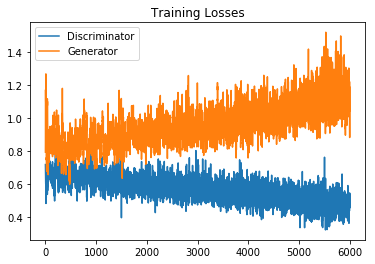

In [106]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

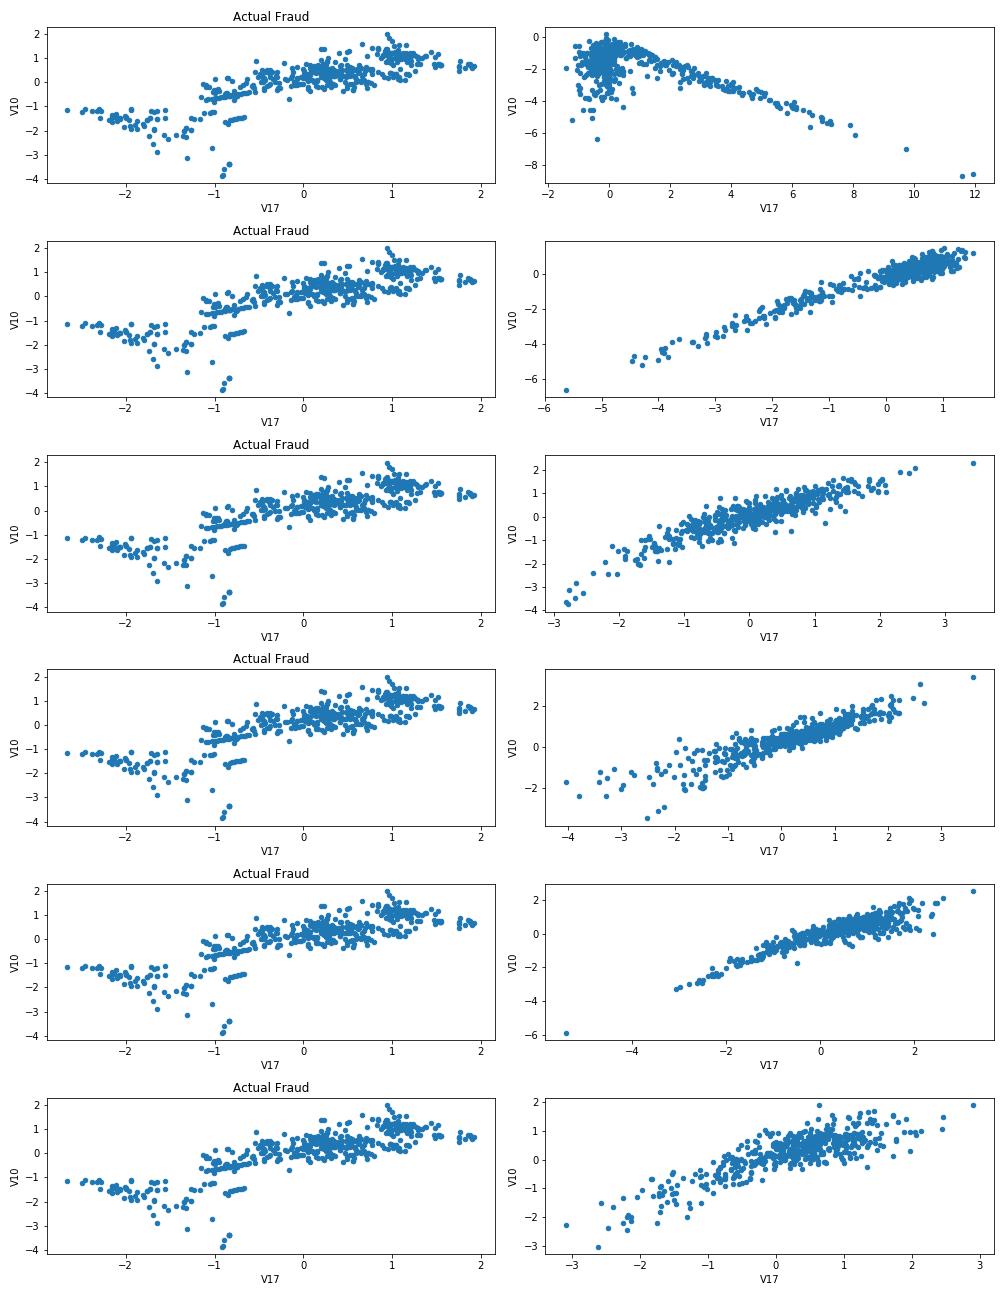

In [107]:
from IPython.display import Image
Image(filename='GANv2-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

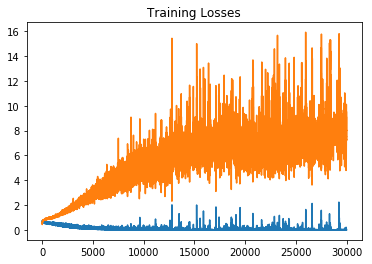

In [68]:
fig

In [36]:
import h5py
import keras
model = keras.models.load_model('cnnv1.h5')

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 1, 256)            7936      
_________________________________________________________________
flatten_24 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 300)               77100     
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 602       
Total params: 85,638
Trainable params: 85,638
Non-trainable params: 0
_________________________________________________________________


In [43]:
def create_model_2():
    # create model
    
    # This returns a tensor
    inputs = Input(shape=(30,1))

    # a layer instance is callable on a tensor, and returns a tensor
    x = Conv1D(256, 30, activation='relu')(inputs)
    x = Conv1D(256, 1, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(300, activation = 'relu')(x)
    x = Dense(100, activation = 'relu')(x)
    
    predictions = Dense(2, activation = 'softmax')(x)

    # This creates a model that includes
    # the Input layer and conv/dense layers
    model = Model(inputs=inputs, outputs=predictions)
    
    sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd)

    return model

In [93]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD

model = create_model_2()
print (model.summary())
noise_shape = (100,)
        
noise = Input(shape=noise_shape)

model.layers.pop(-1)
model.layers.pop(0)
print  (model.summary())

model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1].output]

# model.layers[0].inbound_nodes = []
# model.inputs = noise

layer1 = model.layers[1]


img_rows = 1 
img_cols = 30
channels = 1
img_shape = (img_rows, img_cols, channels)


# inputs = Input(shape=noise_shape)
# model.layers[0].input = noise

print  (model.summary())
model = model(noise)
dense = Dense(np.prod(img_shape))(model.layers[-1].output)
reshape = Reshape(img_shape)(dense)

noise = Input(shape=noise_shape)
model_cnn = Sequential()
model_cnn.add(reshape)

model = model_cnn(noise)
print (model.summary())



# output = Dense(output_dim=10000, activation='relu')(output) # your newlayer Dense(...)
# new_model = Model(model.input, output)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_136 (InputLayer)       (None, 30, 1)             0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 1, 256)            7936      
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 1, 256)            65792     
_________________________________________________________________
flatten_44 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 300)               77100     
_________________________________________________________________
dense_171 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_172 (Dense)            (None, 2)                 202       
Total para

IndexError: list index out of range

In [95]:
model.layers[0].input

<tf.Tensor 'input_136:0' shape=(?, 30, 1) dtype=float32>

In [20]:
model = Model(noise,model)

TypeError: Output tensors to a Model must be Keras tensors. Found: <keras.models.Sequential object at 0x10d381dd0>

In [97]:
model_old = create_model_2()

In [98]:
# This returns a tensor
inputs = Input(shape=(100,1))

# a layer instance is callable on a tensor, and returns a tensor
x = Conv1D(256, 30, activation='relu')(inputs)
x = Conv1D(256, 1, activation='relu')(x)
x = Flatten()(x)
x = Dense(300, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)

predictions = Dense(2, activation = 'softmax')(x)

# This creates a model that includes
# the Input layer and conv/dense layers
model = Model(inputs=inputs, outputs=predictions)

sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [99]:
model.set_weights(model_old.get_weights())

ValueError: Dimension 0 in both shapes must be equal, but are 18176 and 256 for 'Assign_212' (op: 'Assign') with input shapes: [18176,300], [256,300].